# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

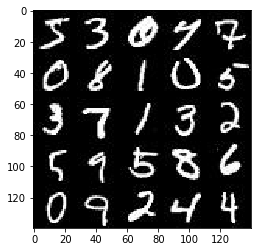

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

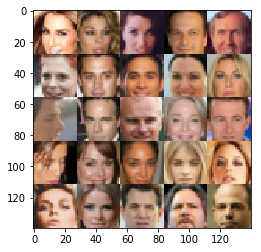

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        # Conv 4
        conv4 = tf.layers.conv2d(lrelu3, 512, 5, 1, 'SAME')
        batch_norm4 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
       
        # Flatten
        flat = tf.reshape(lrelu4, (-1, 7*7*512))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # Fully connected
        fc1 = tf.layers.dense(z, 7*7*512)
        fc1 = tf.reshape(fc1, (-1, 7, 7, 512))
        fc1 = tf.maximum(alpha*fc1, fc1)
        
        # Starting Conv Transpose Stack
        deconv2 = tf.layers.conv2d_transpose(fc1, 256, 3, 1, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 128, 3, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 64, 3, 2, 'SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Logits
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 3, 2, 'SAME')
        
        # Output
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z})
                
                if steps % 100 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
               

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6790... Generator Loss: 2.2776


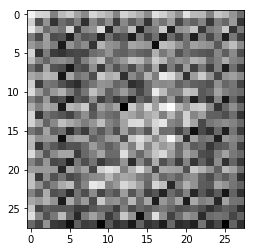

Epoch 1/2... Discriminator Loss: 3.3674... Generator Loss: 0.0706


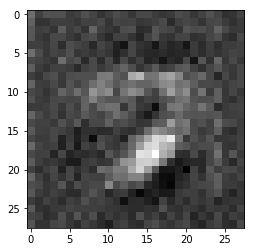

Epoch 1/2... Discriminator Loss: 2.4876... Generator Loss: 6.3686


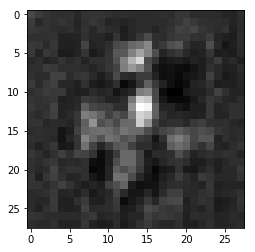

Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.4278


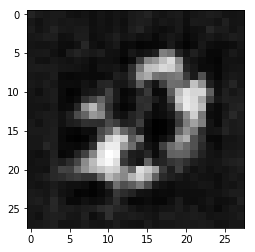

Epoch 1/2... Discriminator Loss: 0.7213... Generator Loss: 2.0331


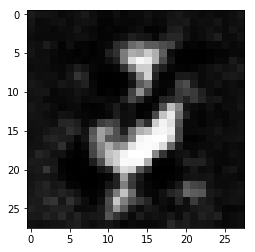

Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 1.1221


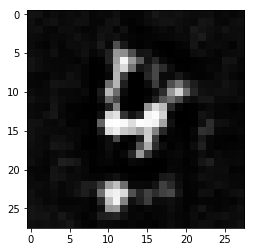

Epoch 1/2... Discriminator Loss: 3.2392... Generator Loss: 0.1231


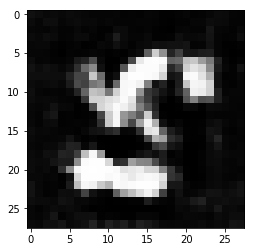

Epoch 1/2... Discriminator Loss: 2.0403... Generator Loss: 4.5305


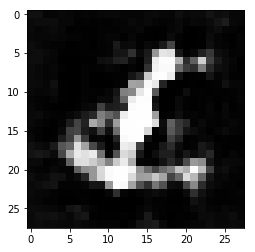

Epoch 1/2... Discriminator Loss: 0.8979... Generator Loss: 2.0597


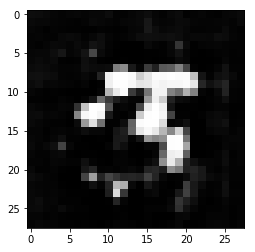

Epoch 1/2... Discriminator Loss: 1.2401... Generator Loss: 0.8125


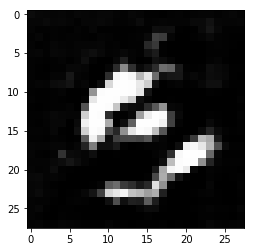

Epoch 1/2... Discriminator Loss: 2.2320... Generator Loss: 0.2465


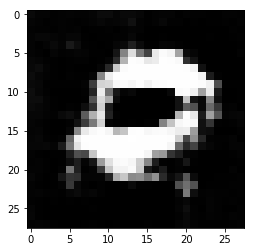

Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 0.4404


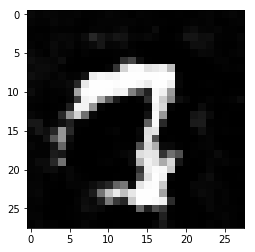

Epoch 1/2... Discriminator Loss: 0.5502... Generator Loss: 2.6395


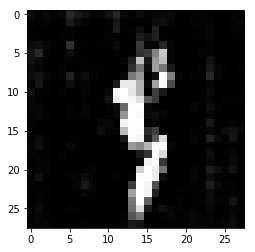

Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 1.7574


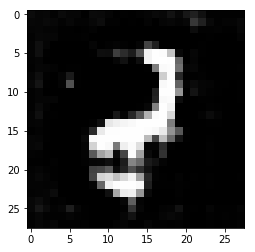

Epoch 1/2... Discriminator Loss: 1.4966... Generator Loss: 0.5310


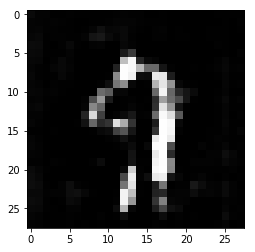

Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 1.2234


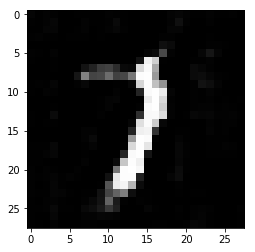

Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 1.3315


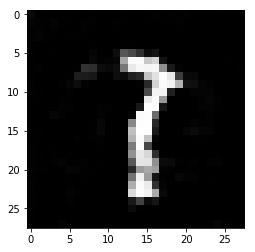

Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 2.4765


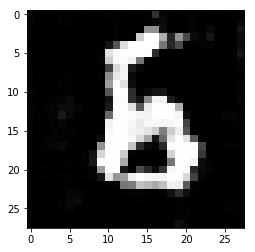

Epoch 1/2... Discriminator Loss: 0.9617... Generator Loss: 4.5538


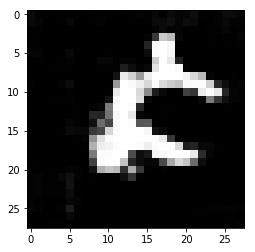

Epoch 1/2... Discriminator Loss: 1.9108... Generator Loss: 4.5621


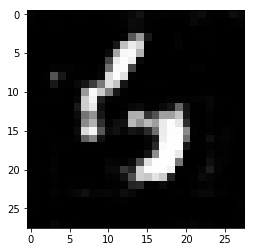

Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 0.5671


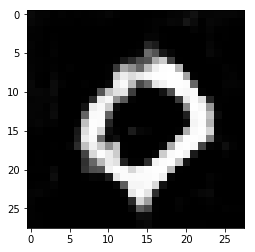

Epoch 1/2... Discriminator Loss: 0.8795... Generator Loss: 1.4366


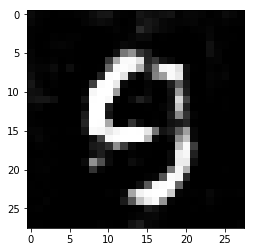

Epoch 1/2... Discriminator Loss: 0.8594... Generator Loss: 1.0866


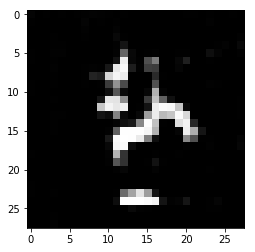

Epoch 1/2... Discriminator Loss: 0.7732... Generator Loss: 1.3377


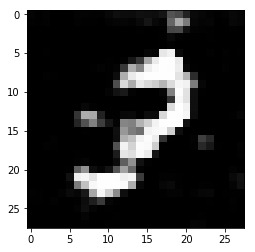

Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 4.1357


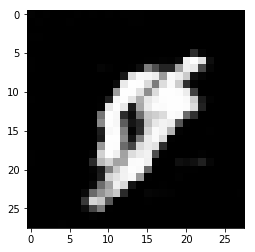

Epoch 1/2... Discriminator Loss: 1.5915... Generator Loss: 0.6058


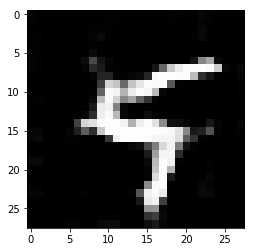

Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.5977


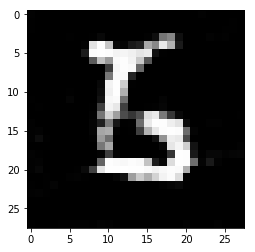

Epoch 1/2... Discriminator Loss: 1.6101... Generator Loss: 0.4902


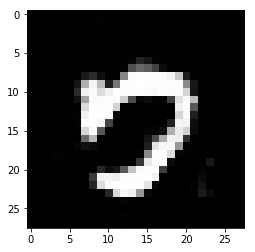

Epoch 1/2... Discriminator Loss: 0.5047... Generator Loss: 2.9835


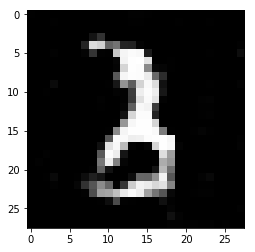

Epoch 1/2... Discriminator Loss: 1.7697... Generator Loss: 3.6803


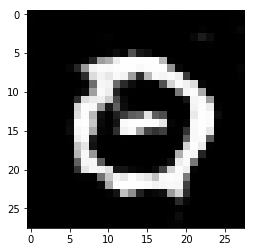

Epoch 1/2... Discriminator Loss: 0.8903... Generator Loss: 1.1472


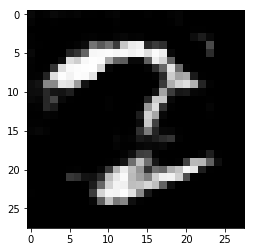

Epoch 1/2... Discriminator Loss: 0.6727... Generator Loss: 2.9547


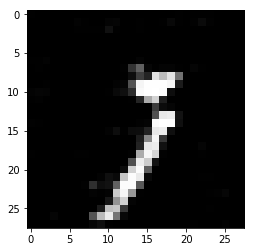

Epoch 1/2... Discriminator Loss: 2.4821... Generator Loss: 0.3997


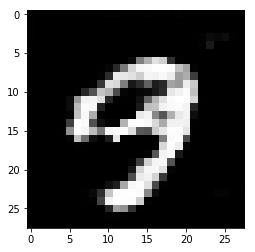

Epoch 1/2... Discriminator Loss: 0.9785... Generator Loss: 1.1407


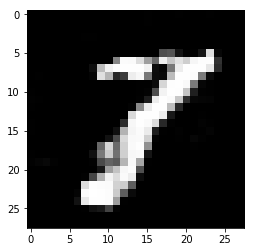

Epoch 1/2... Discriminator Loss: 2.1303... Generator Loss: 0.3792


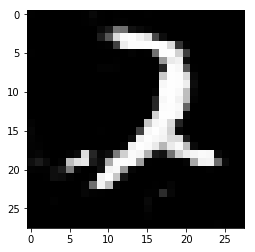

Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 1.3395


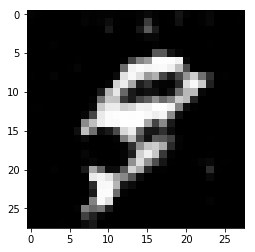

Epoch 1/2... Discriminator Loss: 3.9586... Generator Loss: 0.0727


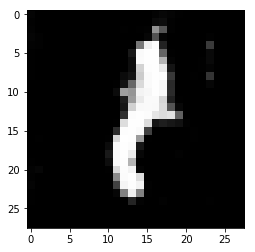

Epoch 1/2... Discriminator Loss: 1.5778... Generator Loss: 0.6147


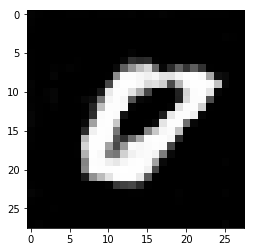

Epoch 1/2... Discriminator Loss: 1.6985... Generator Loss: 0.6101


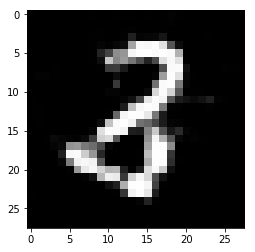

Epoch 1/2... Discriminator Loss: 0.6552... Generator Loss: 2.1967


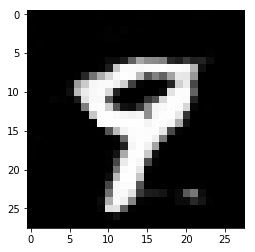

Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.7589


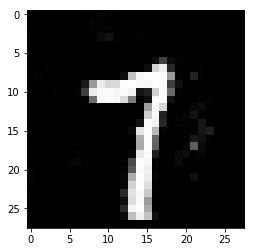

Epoch 1/2... Discriminator Loss: 1.5202... Generator Loss: 0.4524


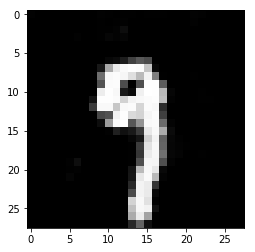

Epoch 1/2... Discriminator Loss: 2.6374... Generator Loss: 0.3124


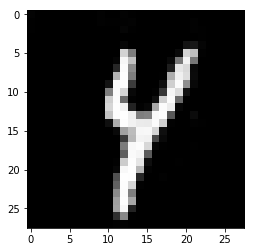

Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 3.3021


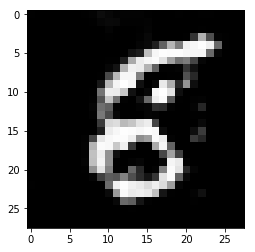

Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 5.6196


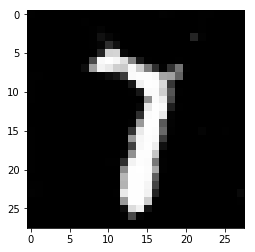

Epoch 1/2... Discriminator Loss: 0.7093... Generator Loss: 3.0369


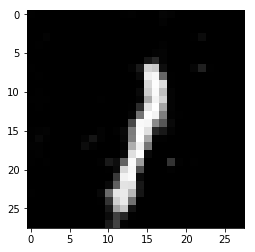

Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 4.0323


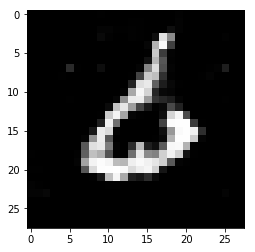

Epoch 1/2... Discriminator Loss: 1.2006... Generator Loss: 0.6230


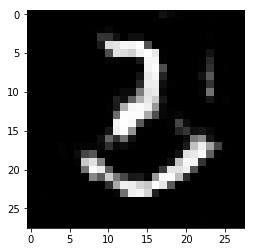

Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.3857


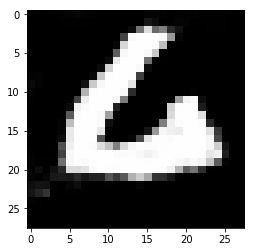

Epoch 1/2... Discriminator Loss: 0.5622... Generator Loss: 1.9666


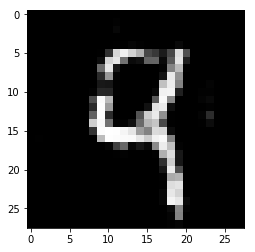

Epoch 1/2... Discriminator Loss: 0.5175... Generator Loss: 2.4010


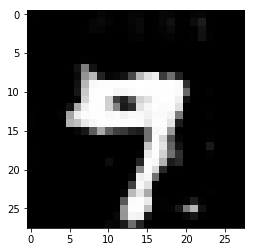

Epoch 1/2... Discriminator Loss: 1.5219... Generator Loss: 0.6856


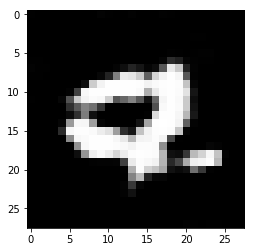

Epoch 1/2... Discriminator Loss: 0.6477... Generator Loss: 1.7116


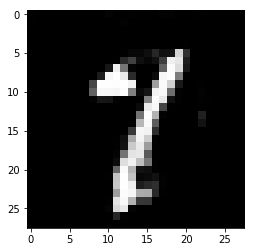

Epoch 1/2... Discriminator Loss: 0.4953... Generator Loss: 2.4371


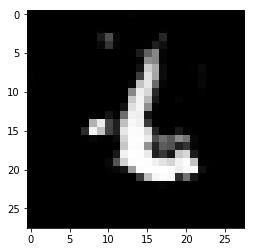

Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.4254


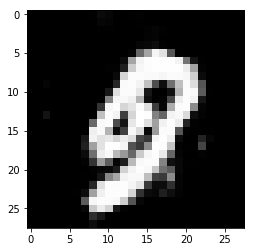

Epoch 1/2... Discriminator Loss: 0.5312... Generator Loss: 2.3669


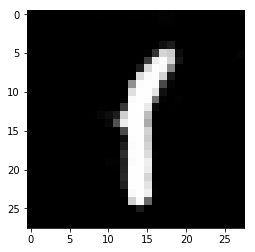

Epoch 1/2... Discriminator Loss: 1.9687... Generator Loss: 0.2943


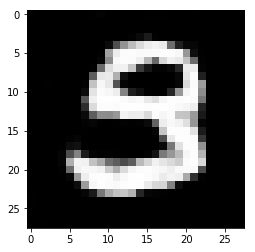

Epoch 1/2... Discriminator Loss: 0.6659... Generator Loss: 2.1834


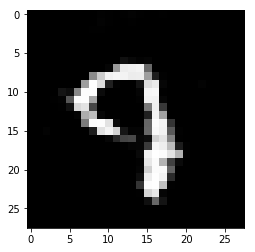

Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 0.8387


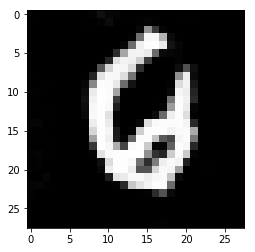

Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 1.1961


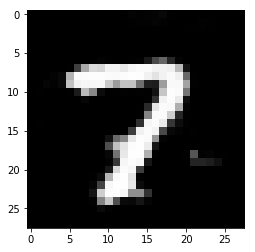

Epoch 2/2... Discriminator Loss: 0.5687... Generator Loss: 1.7182


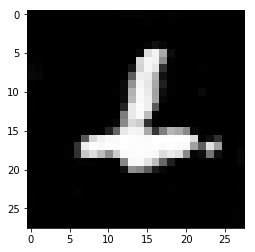

Epoch 2/2... Discriminator Loss: 1.5384... Generator Loss: 1.9072


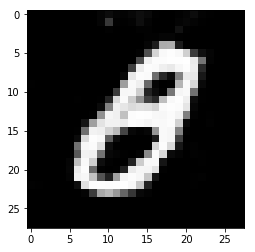

Epoch 2/2... Discriminator Loss: 0.4841... Generator Loss: 2.2949


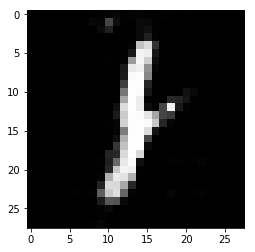

Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.1517


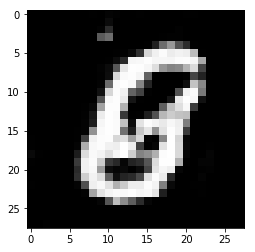

Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.5853


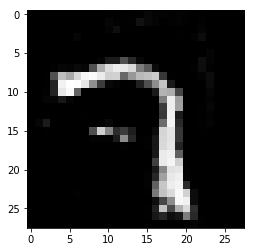

Epoch 2/2... Discriminator Loss: 0.4958... Generator Loss: 2.4893


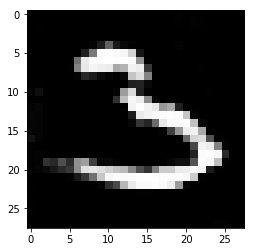

Epoch 2/2... Discriminator Loss: 0.8190... Generator Loss: 1.7557


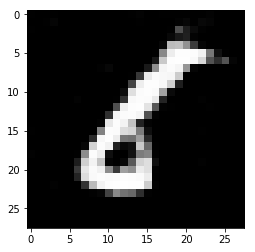

Epoch 2/2... Discriminator Loss: 0.9386... Generator Loss: 1.0893


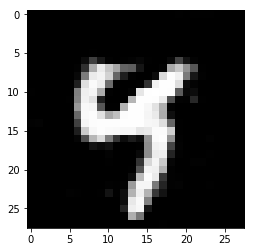

Epoch 2/2... Discriminator Loss: 0.6485... Generator Loss: 1.8738


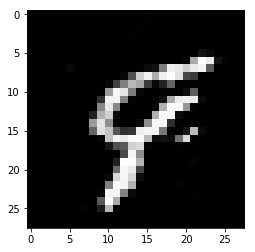

Epoch 2/2... Discriminator Loss: 0.7308... Generator Loss: 1.4109


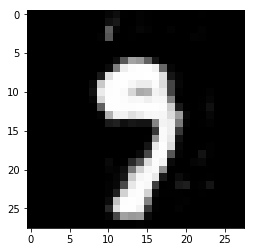

Epoch 2/2... Discriminator Loss: 0.9992... Generator Loss: 2.4767


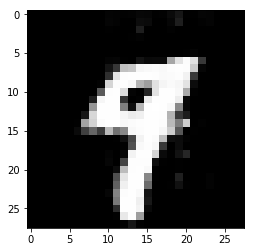

Epoch 2/2... Discriminator Loss: 1.2807... Generator Loss: 0.9328


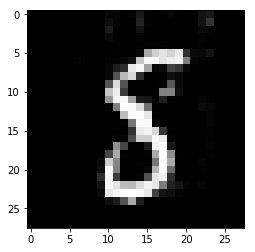

Epoch 2/2... Discriminator Loss: 0.5693... Generator Loss: 2.8556


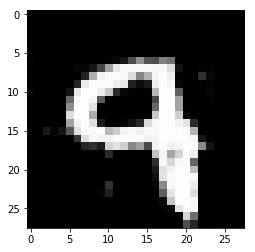

Epoch 2/2... Discriminator Loss: 0.4806... Generator Loss: 2.5504


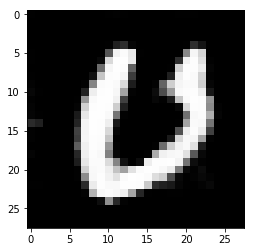

Epoch 2/2... Discriminator Loss: 0.5745... Generator Loss: 1.7329


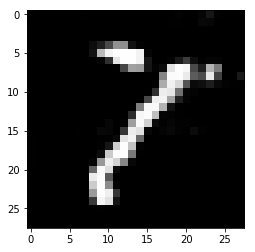

Epoch 2/2... Discriminator Loss: 0.5949... Generator Loss: 2.0447


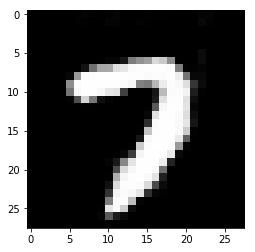

Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.8924


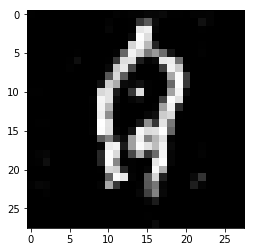

Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.7139


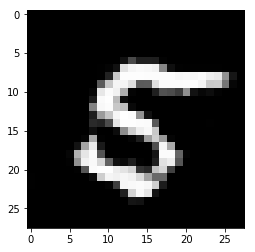

Epoch 2/2... Discriminator Loss: 0.6710... Generator Loss: 2.4110


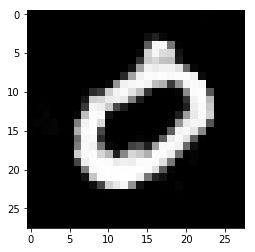

Epoch 2/2... Discriminator Loss: 1.1498... Generator Loss: 3.3552


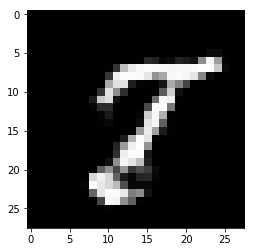

Epoch 2/2... Discriminator Loss: 0.6628... Generator Loss: 1.7452


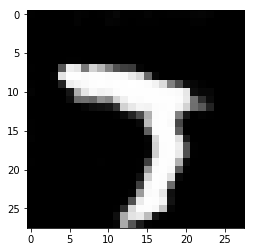

Epoch 2/2... Discriminator Loss: 0.5742... Generator Loss: 2.1012


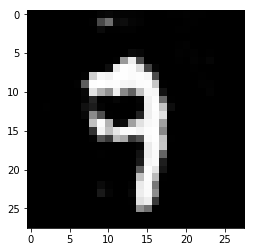

Epoch 2/2... Discriminator Loss: 0.8164... Generator Loss: 1.2095


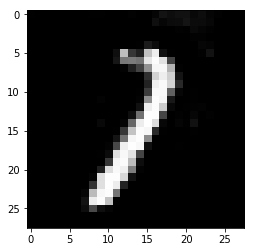

Epoch 2/2... Discriminator Loss: 1.6178... Generator Loss: 0.4633


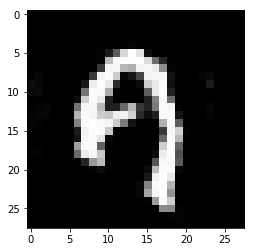

Epoch 2/2... Discriminator Loss: 0.7921... Generator Loss: 1.4350


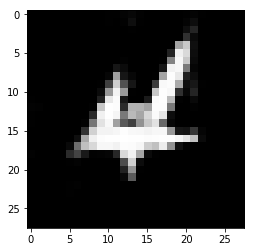

Epoch 2/2... Discriminator Loss: 0.6310... Generator Loss: 1.6933


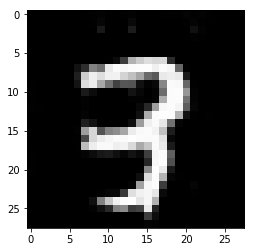

Epoch 2/2... Discriminator Loss: 0.4785... Generator Loss: 2.4345


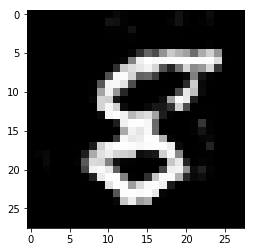

Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 0.9698


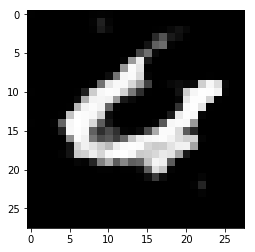

Epoch 2/2... Discriminator Loss: 0.4423... Generator Loss: 2.9350


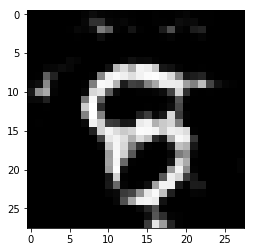

Epoch 2/2... Discriminator Loss: 1.7200... Generator Loss: 0.3666


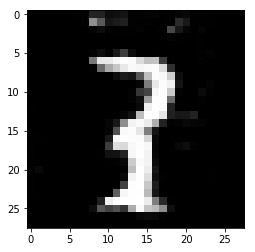

Epoch 2/2... Discriminator Loss: 0.7407... Generator Loss: 1.9634


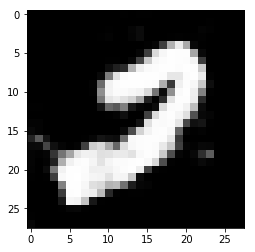

Epoch 2/2... Discriminator Loss: 0.9514... Generator Loss: 3.2942


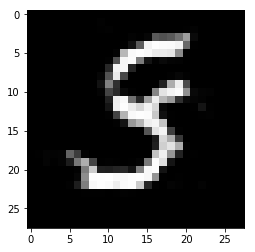

Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 0.9082


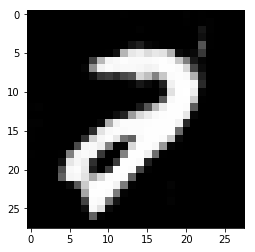

Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 1.3852


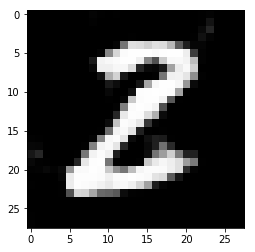

Epoch 2/2... Discriminator Loss: 1.8593... Generator Loss: 0.2945


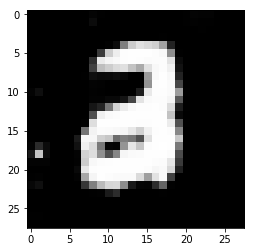

Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 4.5259


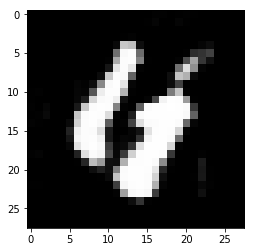

Epoch 2/2... Discriminator Loss: 0.7789... Generator Loss: 1.5831


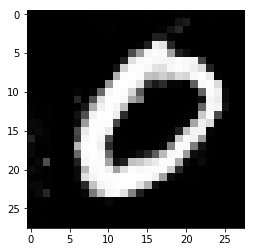

Epoch 2/2... Discriminator Loss: 1.1125... Generator Loss: 0.8884


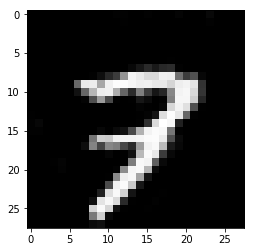

Epoch 2/2... Discriminator Loss: 2.5091... Generator Loss: 0.2794


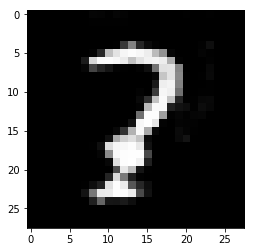

Epoch 2/2... Discriminator Loss: 0.7536... Generator Loss: 1.4520


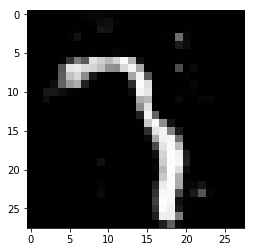

Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.8466


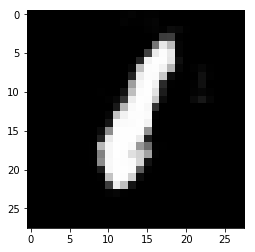

Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.6880


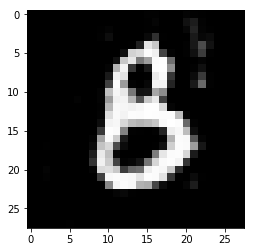

Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.4528


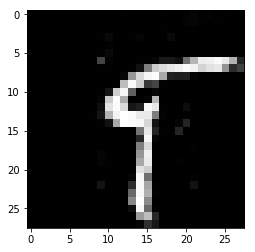

Epoch 2/2... Discriminator Loss: 0.6198... Generator Loss: 1.8554


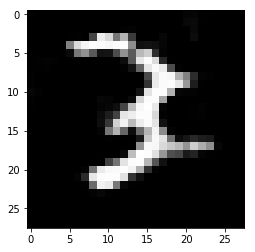

Epoch 2/2... Discriminator Loss: 0.6603... Generator Loss: 2.8007


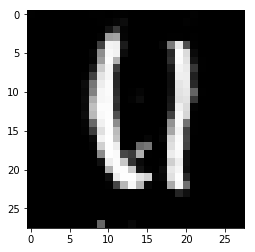

Epoch 2/2... Discriminator Loss: 1.4687... Generator Loss: 0.5026


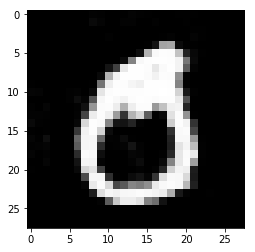

Epoch 2/2... Discriminator Loss: 0.4815... Generator Loss: 3.0674


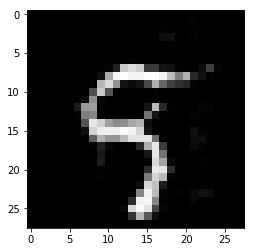

Epoch 2/2... Discriminator Loss: 0.7038... Generator Loss: 1.4764


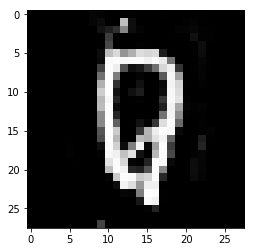

Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.1972


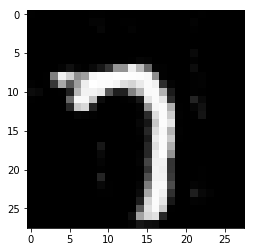

Epoch 2/2... Discriminator Loss: 0.5271... Generator Loss: 2.4967


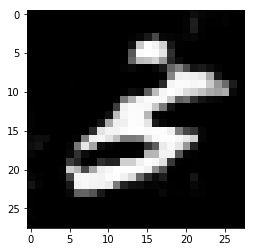

Epoch 2/2... Discriminator Loss: 0.5321... Generator Loss: 2.1155


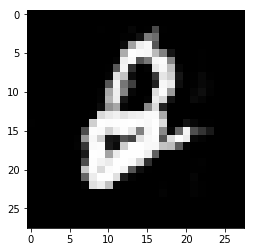

Epoch 2/2... Discriminator Loss: 2.4361... Generator Loss: 0.2385


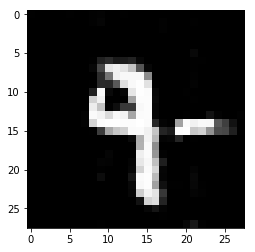

Epoch 2/2... Discriminator Loss: 1.5890... Generator Loss: 0.5143


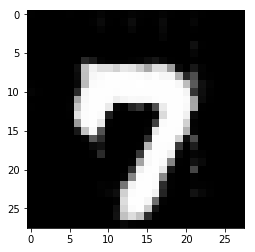

Epoch 2/2... Discriminator Loss: 1.5147... Generator Loss: 0.6954


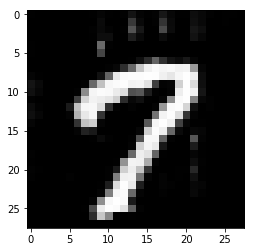

Epoch 2/2... Discriminator Loss: 0.6458... Generator Loss: 1.8323


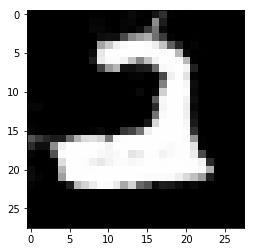

Epoch 2/2... Discriminator Loss: 0.7072... Generator Loss: 2.0322


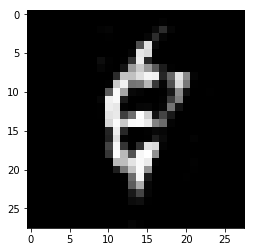

Epoch 2/2... Discriminator Loss: 0.4947... Generator Loss: 2.7868


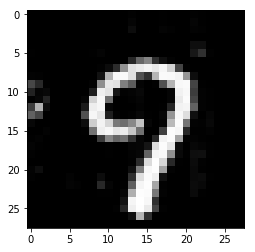

Epoch 2/2... Discriminator Loss: 0.7488... Generator Loss: 1.6252


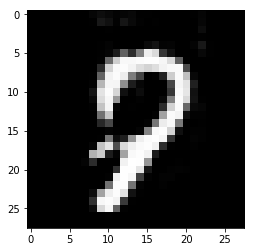

Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.7028


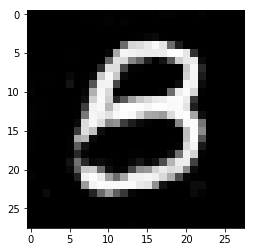

Epoch 2/2... Discriminator Loss: 0.4763... Generator Loss: 2.2808


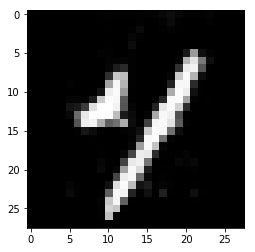

In [18]:
batch_size = 10
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.5983


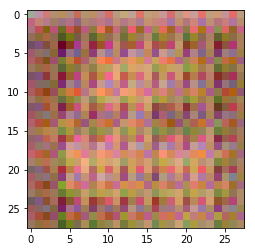

Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.3432


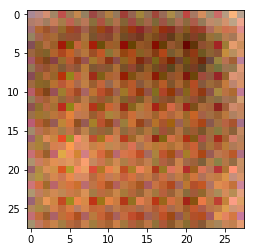

Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 2.7208


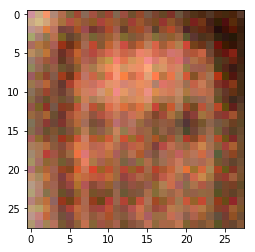

Epoch 1/1... Discriminator Loss: 1.7951... Generator Loss: 0.3380


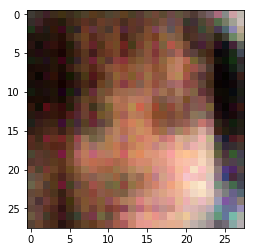

Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 1.0553


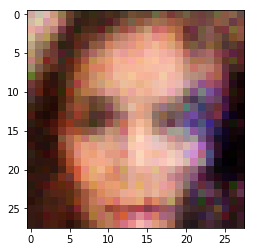

Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.1046


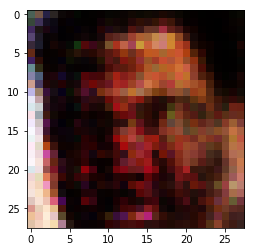

Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7187


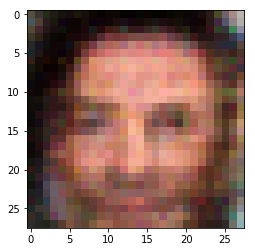

Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 1.1616


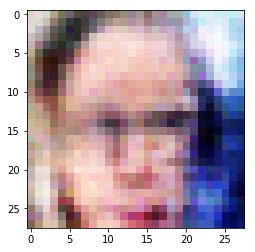

Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.4725


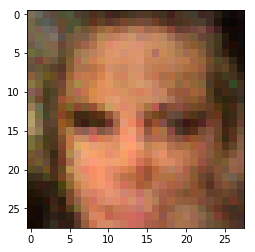

Epoch 1/1... Discriminator Loss: 1.9534... Generator Loss: 2.8267


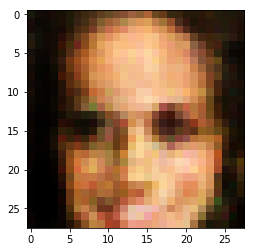

Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 0.3697


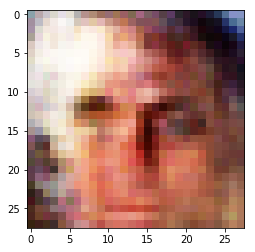

Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.0859


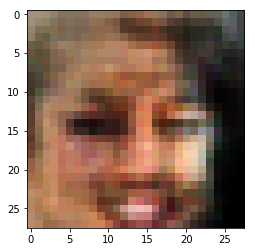

Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.0457


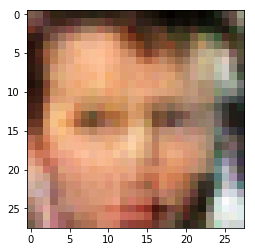

Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.8657


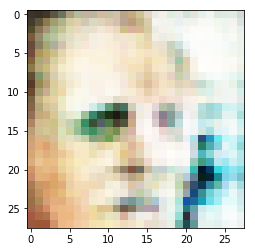

Epoch 1/1... Discriminator Loss: 2.6794... Generator Loss: 0.1711


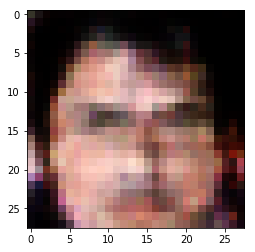

Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.6524


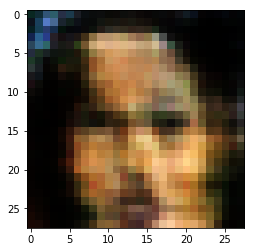

Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 2.1002


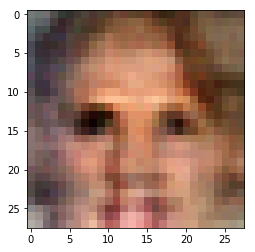

Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 1.4199


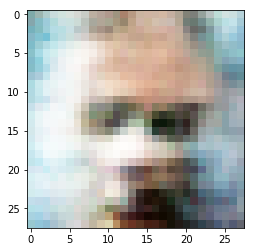

Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 2.3964


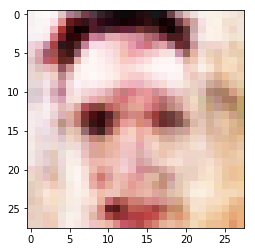

Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 1.0865


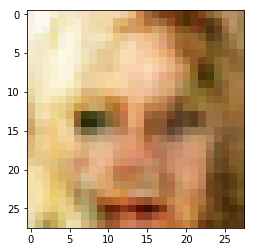

Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 2.0907


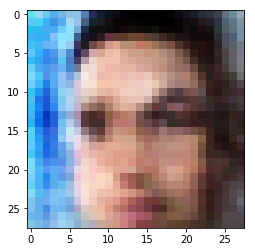

Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 2.8531


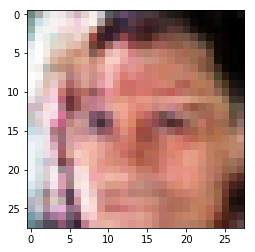

Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 3.6201


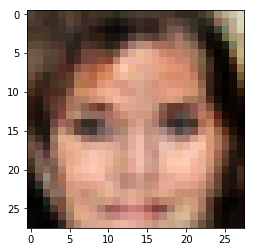

Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.2111


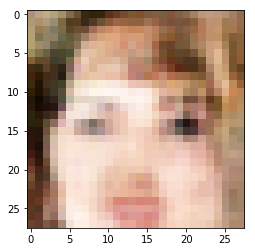

Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 2.3204


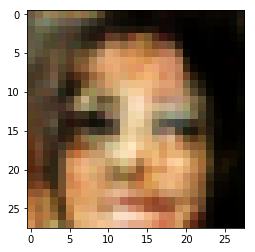

Epoch 1/1... Discriminator Loss: 2.3139... Generator Loss: 0.2550


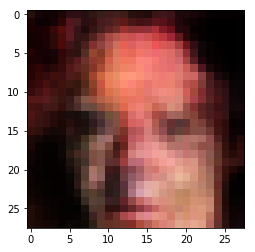

Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 1.8516


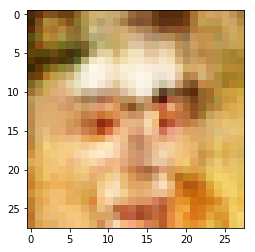

Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 3.0701


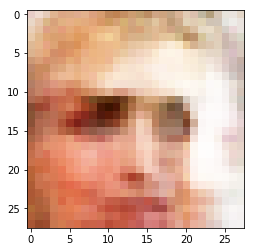

Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 3.8231


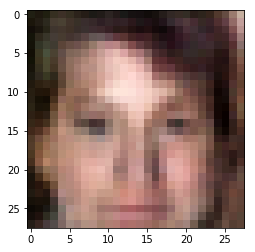

Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.3809


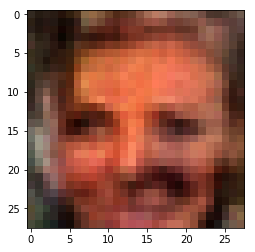

Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.5778


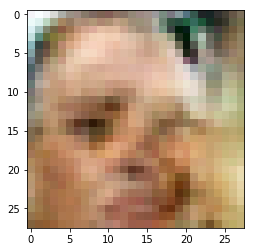

In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.